In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 200
n_loci = 400
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

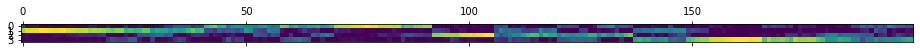

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(200, 400, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 12

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (400, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (200, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
t0 = time.time()
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

print('init time: {:.03f}sec'.format(time.time() - t0))

vb_params_init_dict = deepcopy(vb_params_dict)

init time: 0.094sec


In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_opt_dict['ind_mix_stick_propn_mean'], 
                            vb_opt_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

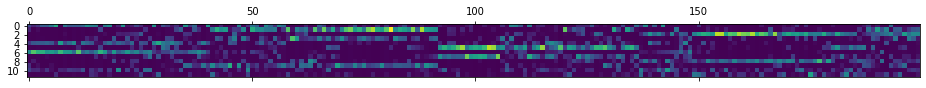

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

In [14]:
## get initial e_z
t0 = time.time()
e_log_sticks, e_log_1m_sticks, \
        e_log_pop_freq, e_log_1m_pop_freq = \
            structure_model_lib.get_moments_from_vb_params_dict(g_obs, \
                                    vb_params_dict, use_logitnormal_sticks)

e_z_init = cavi_lib.update_z(g_obs, e_log_sticks, e_log_1m_sticks, e_log_pop_freq,
                                e_log_1m_pop_freq)

print('e_z_init time: {:.03f}sec'.format(time.time() - t0))

e_z_init time: 0.190sec


# Run CAVI

In [15]:
ez_opt_cavi, vb_cavi_dict, kl_vec_cavi, time_vec_cavi = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        max_iter = 10,
                        f_tol = -1, 
                        x_tol = 1e-2)


iteration [1]; kl:139588.942375; elapsed: 0.6504secs
iteration [2]; kl:117552.988943; elapsed: 0.6651secs
iteration [3]; kl:112940.102026; elapsed: 0.6396secs
iteration [4]; kl:111427.108213; elapsed: 0.636secs
iteration [5]; kl:110764.23772; elapsed: 0.6445secs
iteration [6]; kl:110363.271127; elapsed: 0.6426secs
iteration [7]; kl:110071.350171; elapsed: 0.6397secs
iteration [8]; kl:109842.945002; elapsed: 0.6469secs
iteration [9]; kl:109658.464623; elapsed: 0.7682secs
Done. Warning, max iterations reached. 


# Run SVI

In [19]:
batchsize = 10

In [20]:
ez_opt_svi, vb_svi_dict, kl_vec_svi, time_vec_svi = \
    cavi_lib.run_svi(g_obs, deepcopy(vb_params_init_dict),
                prior_params_dict,
                e_z_init,
                use_logitnormal_sticks,
                batchsize = batchsize,
                x_tol = 1e-2,
                max_iter = 5000,
                print_every = 1, 
                local_x_tol = 1e16)

iteration [1]; kl:237765.625156; elapsed: 0.1136secs
iteration [2]; kl:215742.221475; elapsed: 0.093secs
iteration [3]; kl:206430.07318; elapsed: 0.0884secs
iteration [4]; kl:199527.310972; elapsed: 0.1106secs
iteration [5]; kl:193177.806363; elapsed: 0.0896secs
iteration [6]; kl:188088.490829; elapsed: 0.0871secs
iteration [7]; kl:182398.632209; elapsed: 0.1087secs
iteration [8]; kl:177851.565279; elapsed: 0.0947secs
iteration [9]; kl:175967.742231; elapsed: 0.1573secs
iteration [10]; kl:173046.802112; elapsed: 0.0947secs
iteration [11]; kl:170191.217468; elapsed: 0.0877secs
iteration [12]; kl:166009.339265; elapsed: 0.109secs
iteration [13]; kl:162870.811091; elapsed: 0.0924secs
iteration [14]; kl:160370.825533; elapsed: 0.0862secs
iteration [15]; kl:157820.212329; elapsed: 0.1012secs
iteration [16]; kl:154735.342788; elapsed: 0.0884secs
iteration [17]; kl:153287.045048; elapsed: 0.0863secs
iteration [18]; kl:151274.102146; elapsed: 0.108secs
iteration [19]; kl:149812.89414; elapsed:

iteration [153]; kl:109974.949999; elapsed: 0.1071secs
iteration [154]; kl:109970.262885; elapsed: 0.0903secs
iteration [155]; kl:109961.954905; elapsed: 0.1146secs
iteration [156]; kl:109955.953518; elapsed: 0.0991secs
iteration [157]; kl:109948.052993; elapsed: 0.0876secs
iteration [158]; kl:109941.615841; elapsed: 0.1015secs
iteration [159]; kl:109936.821321; elapsed: 0.0883secs
iteration [160]; kl:109928.12332; elapsed: 0.0859secs
iteration [161]; kl:109920.369589; elapsed: 0.1049secs
iteration [162]; kl:109913.941664; elapsed: 0.0888secs
iteration [163]; kl:109905.403999; elapsed: 0.0889secs
iteration [164]; kl:109894.81477; elapsed: 0.1026secs
iteration [165]; kl:109885.841334; elapsed: 0.0937secs
iteration [166]; kl:109876.092883; elapsed: 0.0964secs
iteration [167]; kl:109871.190777; elapsed: 0.1018secs
iteration [168]; kl:109866.631615; elapsed: 0.0859secs
iteration [169]; kl:109860.163118; elapsed: 0.0861secs
iteration [170]; kl:109850.46688; elapsed: 0.1053secs
iteration [17

iteration [304]; kl:109306.084028; elapsed: 0.1061secs
iteration [305]; kl:109303.51369; elapsed: 0.0969secs
iteration [306]; kl:109300.94202; elapsed: 0.1135secs
iteration [307]; kl:109298.239575; elapsed: 0.0978secs
iteration [308]; kl:109296.120821; elapsed: 0.0869secs
iteration [309]; kl:109293.108305; elapsed: 0.1034secs
iteration [310]; kl:109291.072388; elapsed: 0.1269secs
iteration [311]; kl:109288.071561; elapsed: 0.0916secs
iteration [312]; kl:109285.307574; elapsed: 0.0959secs
iteration [313]; kl:109283.100929; elapsed: 0.0898secs
iteration [314]; kl:109280.420617; elapsed: 0.1026secs
iteration [315]; kl:109278.186065; elapsed: 0.0955secs
iteration [316]; kl:109274.734058; elapsed: 0.0935secs
iteration [317]; kl:109269.448189; elapsed: 0.099secs
iteration [318]; kl:109266.510787; elapsed: 0.0873secs
iteration [319]; kl:109264.493599; elapsed: 0.0859secs
iteration [320]; kl:109262.421207; elapsed: 0.104secs
iteration [321]; kl:109260.118742; elapsed: 0.0882secs
iteration [322

iteration [456]; kl:109005.850955; elapsed: 0.0907secs
iteration [457]; kl:109004.109109; elapsed: 0.0872secs
iteration [458]; kl:109002.703349; elapsed: 0.0872secs
iteration [459]; kl:109001.560679; elapsed: 0.0877secs
iteration [460]; kl:108999.420947; elapsed: 0.088secs
iteration [461]; kl:108997.309161; elapsed: 0.0892secs
iteration [462]; kl:108995.725956; elapsed: 0.1067secs
iteration [463]; kl:108994.165713; elapsed: 0.133secs
iteration [464]; kl:108992.882135; elapsed: 0.0964secs
iteration [465]; kl:108992.137755; elapsed: 0.0905secs
iteration [466]; kl:108990.960891; elapsed: 0.0898secs
iteration [467]; kl:108988.86734; elapsed: 0.0903secs
iteration [468]; kl:108987.278884; elapsed: 0.1012secs
iteration [469]; kl:108986.073836; elapsed: 0.0909secs
iteration [470]; kl:108985.070625; elapsed: 0.0907secs
iteration [471]; kl:108983.807552; elapsed: 0.0881secs
iteration [472]; kl:108982.73483; elapsed: 0.0893secs
iteration [473]; kl:108981.371777; elapsed: 0.0897secs
iteration [474

iteration [606]; kl:108816.575428; elapsed: 0.0891secs
iteration [607]; kl:108815.382601; elapsed: 0.0882secs
iteration [608]; kl:108814.283596; elapsed: 0.0878secs
iteration [609]; kl:108813.319875; elapsed: 0.088secs
iteration [610]; kl:108812.392057; elapsed: 0.0882secs
iteration [611]; kl:108811.493693; elapsed: 0.0919secs
iteration [612]; kl:108810.51861; elapsed: 0.0887secs
iteration [613]; kl:108809.500952; elapsed: 0.0881secs
iteration [614]; kl:108808.635859; elapsed: 0.0885secs
iteration [615]; kl:108807.541385; elapsed: 0.0897secs
iteration [616]; kl:108806.436671; elapsed: 0.0979secs
iteration [617]; kl:108805.25576; elapsed: 0.091secs
iteration [618]; kl:108804.436335; elapsed: 0.0914secs
iteration [619]; kl:108803.399223; elapsed: 0.0879secs
iteration [620]; kl:108802.322696; elapsed: 0.0889secs
iteration [621]; kl:108801.237463; elapsed: 0.09secs
iteration [622]; kl:108799.929631; elapsed: 0.0901secs
iteration [623]; kl:108798.962688; elapsed: 0.0884secs
iteration [624];

iteration [756]; kl:108676.041591; elapsed: 0.0891secs
iteration [757]; kl:108675.157424; elapsed: 0.0889secs
iteration [758]; kl:108674.729492; elapsed: 0.087secs
iteration [759]; kl:108674.176689; elapsed: 0.088secs
iteration [760]; kl:108673.439963; elapsed: 0.0894secs
iteration [761]; kl:108672.71374; elapsed: 0.0875secs
iteration [762]; kl:108672.159781; elapsed: 0.0874secs
iteration [763]; kl:108671.495775; elapsed: 0.087secs
iteration [764]; kl:108670.976708; elapsed: 0.0863secs
iteration [765]; kl:108669.954945; elapsed: 0.0864secs
iteration [766]; kl:108669.305049; elapsed: 0.0873secs
iteration [767]; kl:108668.255968; elapsed: 0.0872secs
iteration [768]; kl:108667.485771; elapsed: 0.0873secs
iteration [769]; kl:108666.555858; elapsed: 0.0869secs
iteration [770]; kl:108665.65297; elapsed: 0.0859secs
iteration [771]; kl:108664.584554; elapsed: 0.0909secs
iteration [772]; kl:108664.168097; elapsed: 0.0858secs
iteration [773]; kl:108663.546609; elapsed: 0.0864secs
iteration [774]

iteration [908]; kl:108559.820371; elapsed: 0.089secs
iteration [909]; kl:108558.867085; elapsed: 0.0881secs
iteration [910]; kl:108557.716826; elapsed: 0.0883secs
iteration [911]; kl:108557.077893; elapsed: 0.0878secs
iteration [912]; kl:108556.468532; elapsed: 0.0881secs
iteration [913]; kl:108555.719909; elapsed: 0.0889secs
iteration [914]; kl:108554.996247; elapsed: 0.0884secs
iteration [915]; kl:108554.294934; elapsed: 0.0904secs
iteration [916]; kl:108553.289822; elapsed: 0.1013secs
iteration [917]; kl:108552.381571; elapsed: 0.1372secs
iteration [918]; kl:108551.608305; elapsed: 0.0954secs
iteration [919]; kl:108550.774266; elapsed: 0.0906secs
iteration [920]; kl:108549.918523; elapsed: 0.0913secs
iteration [921]; kl:108549.307254; elapsed: 0.0921secs
iteration [922]; kl:108548.79633; elapsed: 0.0918secs
iteration [923]; kl:108547.887581; elapsed: 0.095secs
iteration [924]; kl:108547.230261; elapsed: 0.0926secs
iteration [925]; kl:108546.41296; elapsed: 0.0883secs
iteration [926

iteration [1057]; kl:108452.523394; elapsed: 0.0943secs
iteration [1058]; kl:108451.790721; elapsed: 0.0902secs
iteration [1059]; kl:108450.725875; elapsed: 0.0887secs
iteration [1060]; kl:108450.308101; elapsed: 0.0982secs
iteration [1061]; kl:108449.410391; elapsed: 0.0885secs
iteration [1062]; kl:108448.740564; elapsed: 0.1546secs
iteration [1063]; kl:108447.956142; elapsed: 0.1131secs
iteration [1064]; kl:108447.08047; elapsed: 0.1542secs
iteration [1065]; kl:108446.363982; elapsed: 0.1496secs
iteration [1066]; kl:108445.889893; elapsed: 0.1035secs
iteration [1067]; kl:108445.349599; elapsed: 0.1072secs
iteration [1068]; kl:108444.469139; elapsed: 0.0939secs
iteration [1069]; kl:108444.16672; elapsed: 0.1071secs
iteration [1070]; kl:108443.531309; elapsed: 0.1001secs
iteration [1071]; kl:108442.948435; elapsed: 0.0907secs
iteration [1072]; kl:108442.270593; elapsed: 0.0889secs
iteration [1073]; kl:108441.628173; elapsed: 0.0943secs
iteration [1074]; kl:108441.054741; elapsed: 0.089

iteration [1205]; kl:108362.458822; elapsed: 0.0875secs
iteration [1206]; kl:108361.897047; elapsed: 0.0882secs
iteration [1207]; kl:108361.446512; elapsed: 0.0886secs
iteration [1208]; kl:108360.912932; elapsed: 0.0887secs
iteration [1209]; kl:108360.540041; elapsed: 0.093secs
iteration [1210]; kl:108360.117264; elapsed: 0.0888secs
iteration [1211]; kl:108359.739767; elapsed: 0.09secs
iteration [1212]; kl:108359.268804; elapsed: 0.092secs
iteration [1213]; kl:108358.735803; elapsed: 0.1206secs
iteration [1214]; kl:108358.308716; elapsed: 0.122secs
iteration [1215]; kl:108357.789411; elapsed: 0.095secs
iteration [1216]; kl:108357.309192; elapsed: 0.0891secs
iteration [1217]; kl:108356.767305; elapsed: 0.098secs
iteration [1218]; kl:108356.332307; elapsed: 0.0914secs
iteration [1219]; kl:108355.759661; elapsed: 0.0898secs
iteration [1220]; kl:108355.058121; elapsed: 0.087secs
iteration [1221]; kl:108354.195962; elapsed: 0.088secs
iteration [1222]; kl:108353.671048; elapsed: 0.093secs
it

iteration [1355]; kl:108277.673066; elapsed: 0.0834secs
iteration [1356]; kl:108276.664725; elapsed: 0.0831secs
iteration [1357]; kl:108275.968305; elapsed: 0.084secs
iteration [1358]; kl:108275.5088; elapsed: 0.0864secs
iteration [1359]; kl:108274.971201; elapsed: 0.0837secs
iteration [1360]; kl:108274.321573; elapsed: 0.083secs
iteration [1361]; kl:108273.959299; elapsed: 0.0853secs
iteration [1362]; kl:108273.565372; elapsed: 0.083secs
iteration [1363]; kl:108272.98457; elapsed: 0.083secs
iteration [1364]; kl:108272.644384; elapsed: 0.0851secs
iteration [1365]; kl:108271.939101; elapsed: 0.0831secs
iteration [1366]; kl:108271.343023; elapsed: 0.0832secs
iteration [1367]; kl:108270.799749; elapsed: 0.0835secs
iteration [1368]; kl:108270.43411; elapsed: 0.083secs
iteration [1369]; kl:108269.781107; elapsed: 0.0826secs
iteration [1370]; kl:108269.022902; elapsed: 0.0848secs
iteration [1371]; kl:108268.706545; elapsed: 0.1152secs
iteration [1372]; kl:108268.210704; elapsed: 0.098secs
it

iteration [1505]; kl:108197.558006; elapsed: 0.0834secs
iteration [1506]; kl:108197.14425; elapsed: 0.0826secs
iteration [1507]; kl:108196.492299; elapsed: 0.083secs
iteration [1508]; kl:108196.204854; elapsed: 0.0849secs
iteration [1509]; kl:108195.767562; elapsed: 0.0839secs
iteration [1510]; kl:108195.465218; elapsed: 0.0835secs
iteration [1511]; kl:108194.939533; elapsed: 0.0831secs
iteration [1512]; kl:108194.434188; elapsed: 0.0849secs
iteration [1513]; kl:108193.966591; elapsed: 0.0831secs
iteration [1514]; kl:108193.52887; elapsed: 0.0844secs
iteration [1515]; kl:108193.1884; elapsed: 0.0837secs
iteration [1516]; kl:108192.477569; elapsed: 0.0847secs
iteration [1517]; kl:108191.793409; elapsed: 0.0834secs
iteration [1518]; kl:108191.243744; elapsed: 0.0825secs
iteration [1519]; kl:108190.532946; elapsed: 0.0831secs
iteration [1520]; kl:108189.648435; elapsed: 0.0869secs
iteration [1521]; kl:108189.276148; elapsed: 0.0859secs
iteration [1522]; kl:108189.039953; elapsed: 0.0833se

iteration [1654]; kl:108118.877334; elapsed: 0.089secs
iteration [1655]; kl:108118.234632; elapsed: 0.0869secs
iteration [1656]; kl:108117.778685; elapsed: 0.1034secs
iteration [1657]; kl:108117.399574; elapsed: 0.09secs
iteration [1658]; kl:108117.021545; elapsed: 0.0874secs
iteration [1659]; kl:108116.596051; elapsed: 0.0882secs
iteration [1660]; kl:108116.242437; elapsed: 0.0939secs
iteration [1661]; kl:108115.955639; elapsed: 0.0924secs
iteration [1662]; kl:108115.71908; elapsed: 0.0901secs
iteration [1663]; kl:108115.407311; elapsed: 0.1372secs
iteration [1664]; kl:108114.951451; elapsed: 0.147secs
iteration [1665]; kl:108114.143193; elapsed: 0.1077secs
iteration [1666]; kl:108113.673297; elapsed: 0.0902secs
iteration [1667]; kl:108113.4741; elapsed: 0.0865secs
iteration [1668]; kl:108113.240027; elapsed: 0.1014secs
iteration [1669]; kl:108112.683522; elapsed: 0.1002secs
iteration [1670]; kl:108112.354163; elapsed: 0.126secs
iteration [1671]; kl:108111.60079; elapsed: 0.1952secs
i

iteration [1801]; kl:108051.170316; elapsed: 0.1085secs
iteration [1802]; kl:108050.552304; elapsed: 0.0887secs
iteration [1803]; kl:108049.836278; elapsed: 0.0869secs
iteration [1804]; kl:108049.146996; elapsed: 0.0992secs
iteration [1805]; kl:108048.755515; elapsed: 0.1164secs
iteration [1806]; kl:108048.221952; elapsed: 0.0927secs
iteration [1807]; kl:108047.77036; elapsed: 0.1196secs
iteration [1808]; kl:108047.182368; elapsed: 0.097secs
iteration [1809]; kl:108046.614036; elapsed: 0.1065secs
iteration [1810]; kl:108046.000038; elapsed: 0.0961secs
iteration [1811]; kl:108045.292526; elapsed: 0.0938secs
iteration [1812]; kl:108044.538642; elapsed: 0.1239secs
iteration [1813]; kl:108044.275019; elapsed: 0.0955secs
iteration [1814]; kl:108044.028579; elapsed: 0.1156secs
iteration [1815]; kl:108043.527343; elapsed: 0.0901secs
iteration [1816]; kl:108042.738468; elapsed: 0.0887secs
iteration [1817]; kl:108042.227156; elapsed: 0.0985secs
iteration [1818]; kl:108041.772395; elapsed: 0.087

iteration [1948]; kl:107988.063529; elapsed: 0.0898secs
iteration [1949]; kl:107987.476714; elapsed: 0.0945secs
iteration [1950]; kl:107987.222242; elapsed: 0.0908secs
iteration [1951]; kl:107986.721537; elapsed: 0.0888secs
iteration [1952]; kl:107986.467649; elapsed: 0.0889secs
iteration [1953]; kl:107985.982241; elapsed: 0.1041secs
iteration [1954]; kl:107985.526079; elapsed: 0.1709secs
iteration [1955]; kl:107985.210128; elapsed: 0.1566secs
iteration [1956]; kl:107984.848139; elapsed: 0.0956secs
iteration [1957]; kl:107984.38115; elapsed: 0.0894secs
iteration [1958]; kl:107983.880981; elapsed: 0.0877secs
iteration [1959]; kl:107983.537177; elapsed: 0.1053secs
iteration [1960]; kl:107983.115919; elapsed: 0.0914secs
iteration [1961]; kl:107982.857261; elapsed: 0.0876secs
iteration [1962]; kl:107982.516945; elapsed: 0.0927secs
iteration [1963]; kl:107982.134344; elapsed: 0.0911secs
iteration [1964]; kl:107981.855788; elapsed: 0.0914secs
iteration [1965]; kl:107981.430105; elapsed: 0.09

iteration [2096]; kl:107930.840463; elapsed: 0.0881secs
iteration [2097]; kl:107930.399759; elapsed: 0.0997secs
iteration [2098]; kl:107929.886784; elapsed: 0.0907secs
iteration [2099]; kl:107929.476858; elapsed: 0.0883secs
iteration [2100]; kl:107929.122419; elapsed: 0.0865secs
iteration [2101]; kl:107928.577379; elapsed: 0.0874secs
iteration [2102]; kl:107928.110802; elapsed: 0.0969secs
iteration [2103]; kl:107927.560268; elapsed: 0.0864secs
iteration [2104]; kl:107927.069271; elapsed: 0.0863secs
iteration [2105]; kl:107926.780417; elapsed: 0.0895secs
iteration [2106]; kl:107926.390341; elapsed: 0.1039secs
iteration [2107]; kl:107925.723014; elapsed: 0.0897secs
iteration [2108]; kl:107925.47915; elapsed: 0.0893secs
iteration [2109]; kl:107925.203545; elapsed: 0.0883secs
iteration [2110]; kl:107924.805497; elapsed: 0.1066secs
iteration [2111]; kl:107924.335937; elapsed: 0.0949secs
iteration [2112]; kl:107923.616048; elapsed: 0.0874secs
iteration [2113]; kl:107923.377412; elapsed: 0.09

iteration [2243]; kl:107875.448326; elapsed: 0.1211secs
iteration [2244]; kl:107875.172785; elapsed: 0.0956secs
iteration [2245]; kl:107874.604018; elapsed: 0.1095secs
iteration [2246]; kl:107874.105544; elapsed: 0.1046secs
iteration [2247]; kl:107873.808604; elapsed: 0.118secs
iteration [2248]; kl:107873.563063; elapsed: 0.1054secs
iteration [2249]; kl:107873.18317; elapsed: 0.0964secs
iteration [2250]; kl:107872.717054; elapsed: 0.1188secs
iteration [2251]; kl:107872.515891; elapsed: 0.1487secs
iteration [2252]; kl:107872.043713; elapsed: 0.1052secs
iteration [2253]; kl:107871.854592; elapsed: 0.089secs
iteration [2254]; kl:107871.493179; elapsed: 0.1141secs
iteration [2255]; kl:107871.264726; elapsed: 0.089secs
iteration [2256]; kl:107870.666933; elapsed: 0.0878secs
iteration [2257]; kl:107870.428113; elapsed: 0.1015secs
iteration [2258]; kl:107870.151219; elapsed: 0.0885secs
iteration [2259]; kl:107869.810793; elapsed: 0.0895secs
iteration [2260]; kl:107869.563974; elapsed: 0.0899s

iteration [2392]; kl:107821.434722; elapsed: 0.0885secs
iteration [2393]; kl:107820.939178; elapsed: 0.0893secs
iteration [2394]; kl:107820.792589; elapsed: 0.0983secs
iteration [2395]; kl:107820.470238; elapsed: 0.098secs
iteration [2396]; kl:107819.835063; elapsed: 0.089secs
iteration [2397]; kl:107819.466883; elapsed: 0.0867secs
iteration [2398]; kl:107819.046991; elapsed: 0.0923secs
iteration [2399]; kl:107818.757249; elapsed: 0.1044secs
iteration [2400]; kl:107818.520245; elapsed: 0.0845secs
iteration [2401]; kl:107817.92621; elapsed: 0.0861secs
iteration [2402]; kl:107817.69264; elapsed: 0.1101secs
iteration [2403]; kl:107817.198444; elapsed: 0.0853secs
iteration [2404]; kl:107816.954976; elapsed: 0.1188secs
iteration [2405]; kl:107816.559763; elapsed: 0.0914secs
iteration [2406]; kl:107816.321002; elapsed: 0.1004secs
iteration [2407]; kl:107815.960903; elapsed: 0.1214secs
iteration [2408]; kl:107815.609672; elapsed: 0.0876secs
iteration [2409]; kl:107815.266409; elapsed: 0.1096s

iteration [2539]; kl:107768.289481; elapsed: 0.0867secs
iteration [2540]; kl:107767.972757; elapsed: 0.0879secs
iteration [2541]; kl:107767.626678; elapsed: 0.0854secs
iteration [2542]; kl:107767.332095; elapsed: 0.086secs
iteration [2543]; kl:107766.970176; elapsed: 0.0852secs
iteration [2544]; kl:107766.668208; elapsed: 0.0846secs
iteration [2545]; kl:107766.297766; elapsed: 0.0879secs
iteration [2546]; kl:107766.06992; elapsed: 0.0875secs
iteration [2547]; kl:107765.682528; elapsed: 0.0901secs
iteration [2548]; kl:107765.41161; elapsed: 0.0866secs
iteration [2549]; kl:107765.068394; elapsed: 0.093secs
iteration [2550]; kl:107764.718032; elapsed: 0.0873secs
iteration [2551]; kl:107764.452512; elapsed: 0.0863secs
iteration [2552]; kl:107764.215599; elapsed: 0.0868secs
iteration [2553]; kl:107763.847321; elapsed: 0.088secs
iteration [2554]; kl:107763.424868; elapsed: 0.0877secs
iteration [2555]; kl:107763.010564; elapsed: 0.0884secs
iteration [2556]; kl:107762.710382; elapsed: 0.0876se

iteration [2687]; kl:107718.563239; elapsed: 0.0872secs
iteration [2688]; kl:107718.204179; elapsed: 0.0847secs
iteration [2689]; kl:107717.92745; elapsed: 0.0848secs
iteration [2690]; kl:107717.619716; elapsed: 0.0883secs
iteration [2691]; kl:107717.306753; elapsed: 0.0878secs
iteration [2692]; kl:107716.974522; elapsed: 0.0851secs
iteration [2693]; kl:107716.602976; elapsed: 0.0861secs
iteration [2694]; kl:107716.407436; elapsed: 0.085secs
iteration [2695]; kl:107716.182148; elapsed: 0.0851secs
iteration [2696]; kl:107715.839216; elapsed: 0.088secs
iteration [2697]; kl:107715.259876; elapsed: 0.0869secs
iteration [2698]; kl:107714.887922; elapsed: 0.0852secs
iteration [2699]; kl:107714.712686; elapsed: 0.0859secs
iteration [2700]; kl:107714.428949; elapsed: 0.0856secs
iteration [2701]; kl:107713.987013; elapsed: 0.0856secs
iteration [2702]; kl:107713.649772; elapsed: 0.0876secs
iteration [2703]; kl:107713.211211; elapsed: 0.0852secs
iteration [2704]; kl:107712.799584; elapsed: 0.0851

iteration [2835]; kl:107673.166276; elapsed: 0.0849secs
iteration [2836]; kl:107672.816178; elapsed: 0.0835secs
iteration [2837]; kl:107672.594857; elapsed: 0.1002secs
iteration [2838]; kl:107672.274878; elapsed: 0.0907secs
iteration [2839]; kl:107672.013054; elapsed: 0.085secs
iteration [2840]; kl:107671.757979; elapsed: 0.0871secs
iteration [2841]; kl:107671.321569; elapsed: 0.0892secs
iteration [2842]; kl:107671.06038; elapsed: 0.0955secs
iteration [2843]; kl:107670.572258; elapsed: 0.0852secs
iteration [2844]; kl:107670.222328; elapsed: 0.0853secs
iteration [2845]; kl:107669.985443; elapsed: 0.0845secs
iteration [2846]; kl:107669.6855; elapsed: 0.0996secs
iteration [2847]; kl:107669.332866; elapsed: 0.09secs
iteration [2848]; kl:107669.082251; elapsed: 0.0847secs
iteration [2849]; kl:107668.747084; elapsed: 0.085secs
iteration [2850]; kl:107668.482471; elapsed: 0.0885secs
iteration [2851]; kl:107668.236484; elapsed: 0.0981secs
iteration [2852]; kl:107667.98689; elapsed: 0.0858secs


iteration [2983]; kl:107629.571379; elapsed: 0.0865secs
iteration [2984]; kl:107629.346965; elapsed: 0.0875secs
iteration [2985]; kl:107629.100999; elapsed: 0.0847secs
iteration [2986]; kl:107628.675499; elapsed: 0.0882secs
iteration [2987]; kl:107628.505043; elapsed: 0.0862secs
iteration [2988]; kl:107628.044768; elapsed: 0.0851secs
iteration [2989]; kl:107627.749087; elapsed: 0.0859secs
iteration [2990]; kl:107627.371835; elapsed: 0.0851secs
iteration [2991]; kl:107627.058809; elapsed: 0.0856secs
iteration [2992]; kl:107626.64991; elapsed: 0.0866secs
iteration [2993]; kl:107626.464893; elapsed: 0.0922secs
iteration [2994]; kl:107626.215001; elapsed: 0.0856secs
iteration [2995]; kl:107625.899959; elapsed: 0.088secs
iteration [2996]; kl:107625.566775; elapsed: 0.0864secs
iteration [2997]; kl:107625.353351; elapsed: 0.0851secs
iteration [2998]; kl:107625.248487; elapsed: 0.0876secs
iteration [2999]; kl:107624.959201; elapsed: 0.0863secs
iteration [3000]; kl:107624.601299; elapsed: 0.085

iteration [3132]; kl:107585.693108; elapsed: 0.0865secs
iteration [3133]; kl:107585.484291; elapsed: 0.0871secs
iteration [3134]; kl:107585.112854; elapsed: 0.0859secs
iteration [3135]; kl:107584.841244; elapsed: 0.0869secs
iteration [3136]; kl:107584.553156; elapsed: 0.0866secs
iteration [3137]; kl:107584.236117; elapsed: 0.0854secs
iteration [3138]; kl:107583.771623; elapsed: 0.0871secs
iteration [3139]; kl:107583.432262; elapsed: 0.0852secs
iteration [3140]; kl:107583.156849; elapsed: 0.0848secs
iteration [3141]; kl:107582.765964; elapsed: 0.0871secs
iteration [3142]; kl:107582.534004; elapsed: 0.0861secs
iteration [3143]; kl:107582.288109; elapsed: 0.0916secs
iteration [3144]; kl:107582.027424; elapsed: 0.1129secs
iteration [3145]; kl:107581.772727; elapsed: 0.0933secs
iteration [3146]; kl:107581.48445; elapsed: 0.086secs
iteration [3147]; kl:107581.198269; elapsed: 0.0878secs
iteration [3148]; kl:107580.909069; elapsed: 0.0854secs
iteration [3149]; kl:107580.647117; elapsed: 0.086

iteration [3280]; kl:107544.280561; elapsed: 0.0898secs
iteration [3281]; kl:107544.113918; elapsed: 0.0978secs
iteration [3282]; kl:107543.772402; elapsed: 0.0868secs
iteration [3283]; kl:107543.599292; elapsed: 0.0869secs
iteration [3284]; kl:107543.249674; elapsed: 0.0884secs
iteration [3285]; kl:107542.980874; elapsed: 0.0946secs
iteration [3286]; kl:107542.733256; elapsed: 0.0892secs
iteration [3287]; kl:107542.443828; elapsed: 0.0846secs
iteration [3288]; kl:107542.09179; elapsed: 0.0839secs
iteration [3289]; kl:107541.785394; elapsed: 0.0875secs
iteration [3290]; kl:107541.577875; elapsed: 0.0964secs
iteration [3291]; kl:107541.104218; elapsed: 0.0858secs
iteration [3292]; kl:107540.884482; elapsed: 0.0855secs
iteration [3293]; kl:107540.703448; elapsed: 0.0845secs
iteration [3294]; kl:107540.469598; elapsed: 0.0941secs
iteration [3295]; kl:107540.239223; elapsed: 0.0927secs
iteration [3296]; kl:107539.798987; elapsed: 0.0881secs
iteration [3297]; kl:107539.468133; elapsed: 0.08

iteration [3428]; kl:107504.193038; elapsed: 0.0861secs
iteration [3429]; kl:107504.008204; elapsed: 0.0854secs
iteration [3430]; kl:107503.743138; elapsed: 0.1029secs
iteration [3431]; kl:107503.545673; elapsed: 0.0892secs
iteration [3432]; kl:107503.325678; elapsed: 0.0985secs
iteration [3433]; kl:107503.109765; elapsed: 0.1379secs
iteration [3434]; kl:107502.897071; elapsed: 0.1036secs
iteration [3435]; kl:107502.662445; elapsed: 0.0879secs
iteration [3436]; kl:107502.459685; elapsed: 0.0868secs
iteration [3437]; kl:107502.195423; elapsed: 0.0856secs
iteration [3438]; kl:107502.090006; elapsed: 0.0975secs
iteration [3439]; kl:107501.787821; elapsed: 0.0912secs
iteration [3440]; kl:107501.50608; elapsed: 0.086secs
iteration [3441]; kl:107501.120963; elapsed: 0.085secs
iteration [3442]; kl:107500.95793; elapsed: 0.0866secs
iteration [3443]; kl:107500.569301; elapsed: 0.1049secs
iteration [3444]; kl:107500.371347; elapsed: 0.0873secs
iteration [3445]; kl:107500.175107; elapsed: 0.0883s

iteration [3576]; kl:107462.976201; elapsed: 0.1126secs
iteration [3577]; kl:107462.712965; elapsed: 0.1004secs
iteration [3578]; kl:107462.340314; elapsed: 0.089secs
iteration [3579]; kl:107461.8933; elapsed: 0.0998secs
iteration [3580]; kl:107461.732971; elapsed: 0.1179secs
iteration [3581]; kl:107461.537359; elapsed: 0.1165secs
iteration [3582]; kl:107461.300714; elapsed: 0.1052secs
iteration [3583]; kl:107461.074979; elapsed: 0.0945secs
iteration [3584]; kl:107460.867723; elapsed: 0.0945secs
iteration [3585]; kl:107460.515406; elapsed: 0.1079secs
iteration [3586]; kl:107460.282508; elapsed: 0.1121secs
iteration [3587]; kl:107460.032916; elapsed: 0.1106secs
iteration [3588]; kl:107459.815847; elapsed: 0.0936secs
iteration [3589]; kl:107459.498429; elapsed: 0.0849secs
iteration [3590]; kl:107459.261384; elapsed: 0.1048secs
iteration [3591]; kl:107459.068743; elapsed: 0.0978secs
iteration [3592]; kl:107458.756709; elapsed: 0.1206secs
iteration [3593]; kl:107458.599623; elapsed: 0.1162

iteration [3724]; kl:107422.779805; elapsed: 0.1321secs
iteration [3725]; kl:107422.370978; elapsed: 0.1031secs
iteration [3726]; kl:107422.147367; elapsed: 0.1264secs
iteration [3727]; kl:107421.904458; elapsed: 0.0934secs
iteration [3728]; kl:107421.462128; elapsed: 0.0957secs
iteration [3729]; kl:107421.134961; elapsed: 0.1026secs
iteration [3730]; kl:107420.849499; elapsed: 0.1045secs
iteration [3731]; kl:107420.095155; elapsed: 0.1205secs
iteration [3732]; kl:107419.866583; elapsed: 0.0909secs
iteration [3733]; kl:107419.654191; elapsed: 0.1002secs
iteration [3734]; kl:107419.391907; elapsed: 0.104secs
iteration [3735]; kl:107419.13617; elapsed: 0.0907secs
iteration [3736]; kl:107418.667095; elapsed: 0.1048secs
iteration [3737]; kl:107418.207939; elapsed: 0.1287secs
iteration [3738]; kl:107417.990071; elapsed: 0.0946secs
iteration [3739]; kl:107417.719376; elapsed: 0.095secs
iteration [3740]; kl:107417.438158; elapsed: 0.1113secs
iteration [3741]; kl:107417.004943; elapsed: 0.1067

iteration [3873]; kl:107380.782521; elapsed: 0.0942secs
iteration [3874]; kl:107380.48843; elapsed: 0.087secs
iteration [3875]; kl:107380.29093; elapsed: 0.0853secs
iteration [3876]; kl:107380.137831; elapsed: 0.1024secs
iteration [3877]; kl:107379.971532; elapsed: 0.0917secs
iteration [3878]; kl:107379.808178; elapsed: 0.086secs
iteration [3879]; kl:107379.420933; elapsed: 0.1022secs
iteration [3880]; kl:107379.051634; elapsed: 0.087secs
iteration [3881]; kl:107378.46785; elapsed: 0.0927secs
iteration [3882]; kl:107378.224518; elapsed: 0.092secs
iteration [3883]; kl:107377.929783; elapsed: 0.0883secs
iteration [3884]; kl:107377.62903; elapsed: 0.085secs
iteration [3885]; kl:107377.378212; elapsed: 0.0951secs
iteration [3886]; kl:107377.115009; elapsed: 0.1041secs
iteration [3887]; kl:107376.734337; elapsed: 0.0956secs
iteration [3888]; kl:107376.37536; elapsed: 0.0975secs
iteration [3889]; kl:107376.087586; elapsed: 0.1031secs
iteration [3890]; kl:107375.914665; elapsed: 0.0961secs
it

iteration [4021]; kl:107341.332117; elapsed: 0.1241secs
iteration [4022]; kl:107341.101035; elapsed: 0.1021secs
iteration [4023]; kl:107340.920924; elapsed: 0.1067secs
iteration [4024]; kl:107340.702055; elapsed: 0.1221secs
iteration [4025]; kl:107340.450553; elapsed: 0.1106secs
iteration [4026]; kl:107340.184649; elapsed: 0.1117secs
iteration [4027]; kl:107339.960834; elapsed: 0.1347secs
iteration [4028]; kl:107339.842457; elapsed: 0.094secs
iteration [4029]; kl:107339.233626; elapsed: 0.0869secs
iteration [4030]; kl:107338.97678; elapsed: 0.1091secs
iteration [4031]; kl:107338.630852; elapsed: 0.1131secs
iteration [4032]; kl:107338.332921; elapsed: 0.0855secs
iteration [4033]; kl:107337.711707; elapsed: 0.0874secs
iteration [4034]; kl:107337.495151; elapsed: 0.1222secs
iteration [4035]; kl:107337.254086; elapsed: 0.1208secs
iteration [4036]; kl:107336.978039; elapsed: 0.1332secs
iteration [4037]; kl:107336.702959; elapsed: 0.1097secs
iteration [4038]; kl:107336.390957; elapsed: 0.093

iteration [4169]; kl:107301.781081; elapsed: 0.1044secs
iteration [4170]; kl:107301.567845; elapsed: 0.0969secs
iteration [4171]; kl:107301.121729; elapsed: 0.087secs
iteration [4172]; kl:107300.825503; elapsed: 0.111secs
iteration [4173]; kl:107300.569313; elapsed: 0.0966secs
iteration [4174]; kl:107300.156065; elapsed: 0.0895secs
iteration [4175]; kl:107299.980085; elapsed: 0.1048secs
iteration [4176]; kl:107299.671135; elapsed: 0.09secs
iteration [4177]; kl:107299.492159; elapsed: 0.1187secs
iteration [4178]; kl:107299.042215; elapsed: 0.1046secs
iteration [4179]; kl:107298.691478; elapsed: 0.086secs
iteration [4180]; kl:107298.41873; elapsed: 0.0964secs
iteration [4181]; kl:107298.146536; elapsed: 0.095secs
iteration [4182]; kl:107297.891423; elapsed: 0.0885secs
iteration [4183]; kl:107297.644247; elapsed: 0.1124secs
iteration [4184]; kl:107297.339974; elapsed: 0.1055secs
iteration [4185]; kl:107296.818219; elapsed: 0.094secs
iteration [4186]; kl:107296.556185; elapsed: 0.1218secs


iteration [4317]; kl:107263.294715; elapsed: 0.1071secs
iteration [4318]; kl:107263.112914; elapsed: 0.0949secs
iteration [4319]; kl:107262.865494; elapsed: 0.0859secs
iteration [4320]; kl:107262.643717; elapsed: 0.1022secs
iteration [4321]; kl:107262.285047; elapsed: 0.1252secs


KeyboardInterrupt: 